## Tải dữ liệu

In [ ]:
import kagglehub

path = kagglehub.dataset_download("ashishjangra27/face-mask-12k-images-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/face-mask-12k-images-dataset


## Thư viện

In [3]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## Xử lý dữ liệu

In [ ]:
dataset_path = os.path.join(path, "Face Mask Dataset")
train_dir = os.path.join(dataset_path, "Train")
val_dir = os.path.join(dataset_path, "Validation")
test_dir = os.path.join(dataset_path, "Test")

In [29]:
image_size = (224, 224)
batch_size = 32
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode="nearest",
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=image_size,
                                               batch_size=batch_size,
                                               class_mode='categorical')

val_data = val_datagen.flow_from_directory(val_dir,
                                           target_size=image_size,
                                           batch_size=batch_size,
                                           class_mode='categorical')


Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


## Train Model

In [ ]:

INIT_LR = 1e-4
EPOCHS = 20
BS = 32

baseModel = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])


early_stop = EarlyStopping(
    monitor="val_loss",   
    patience=3,           
    restore_best_weights=True
)
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	train_data,
	validation_data=val_data,
	epochs=EPOCHS,
	callbacks=[early_stop])

[INFO] compiling model...
[INFO] training head...


/usr/local/lib/python3.12/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 170s 512ms/step - accuracy: 0.8102 - loss: 0.4364 - val_accuracy: 0.9787 - val_loss: 0.0797
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 151s 484ms/step - accuracy: 0.9595 - loss: 0.1186 - val_accuracy: 0.9875 - val_loss: 0.0536
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 204s 491ms/step - accuracy: 0.9734 - loss: 0.0804 - val_accuracy: 0.9900 - val_loss: 0.0408
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 154s 491ms/step - accuracy: 0.9775 - loss: 0.0751 - val_accuracy: 0.9900 - val_loss: 0.0362
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 154s 491ms/step - accuracy: 0.9808 - loss: 0.0636 - val_accuracy: 0.9937 - val_loss: 0.0306
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 203s 493ms/step - accuracy: 0.9796 - loss: 0.0623 - val_accuracy: 0.9925 - val_loss: 0.0283
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 155s 495ms/step - accuracy: 0.9819 - loss: 0.0581 - val_accuracy: 0.9912 - val_loss: 0.0271
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 150s 478ms/step - accuracy: 0.9848 -

## Training Curve

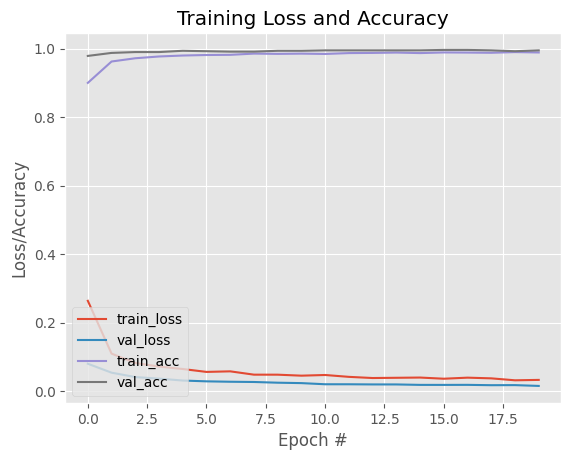

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# plot the training loss and accuracy
N = 20
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

## Đánh giá trên tập test

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
# ===== Dự đoán trên test set =====
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)   # nhãn dự đoán
y_true = test_data.classes                   # nhãn thật

class_labels = list(test_data.class_indices.keys())

# ===== In classification report =====
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

31/31 ━━━━━━━━━━━━━━━━━━━━ 122s 4s/step
              precision    recall  f1-score   support

    WithMask       0.99      1.00      0.99       483
 WithoutMask       1.00      0.99      0.99       509

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992



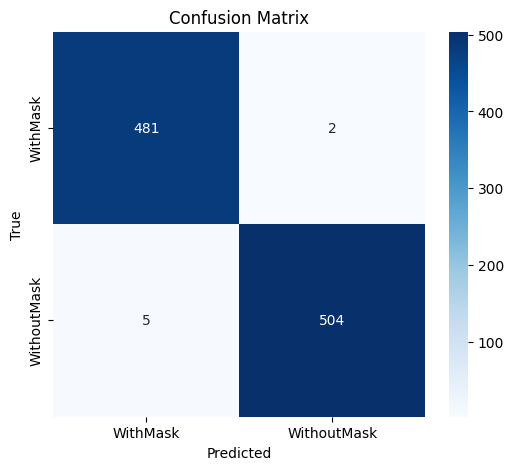

In [13]:
# ===== Confusion matrix =====
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
test_data = val_datagen.flow_from_directory(test_dir,
                                            target_size=image_size,
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            shuffle=False)

loss, acc = model.evaluate(test_data)
print(f"Độ chính xác trên tập test: {acc*100:.2f}%")

Found 992 images belonging to 2 classes.


d:\app\anaconda\envs\py310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 127s 4s/step - accuracy: 0.9929 - loss: 0.0232
Độ chính xác trên tập test: 99.29%


## Lưu model

In [14]:
model.save('model.keras')